In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve, KFold, train_test_split
from sklearn import naive_bayes
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
import seaborn as sns
from imblearn.pipeline import Pipeline, make_pipeline


from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

RANDOM_SEED = 6    # Set a random seed for reproducibility!

/kaggle/input/fare-dataset/test.csv
/kaggle/input/fare-dataset/train.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/fare-dataset/train.csv", index_col="tripid")
test_df = pd.read_csv("/kaggle/input/fare-dataset/test.csv", index_col="tripid")

In [3]:
train_df['label'].value_counts()

correct      15495
incorrect     1681
Name: label, dtype: int64

In [4]:
train_df["label"] = train_df["label"].map({"incorrect": 0, "correct":1})

In [5]:
train_df["pickup"] = pd.to_datetime(train_df["pickup_time"])
train_df["drop"] = pd.to_datetime(train_df["drop_time"])
train_df ['difference'] = train_df["drop"] - train_df["pickup"]
train_df ['difference'] = train_df ['difference']/np.timedelta64(1,'s')
train_df['duration'] = train_df['duration'].fillna(train_df ['difference'])

#train_df['pickup_hour'] = train_df["pickup"].dt.hour

train_df['travel_time'] = train_df['duration'] - train_df['meter_waiting']
#train_df['travel_fare'] = train_df['fare'] - train_df['meter_waiting_fare'] - train_df['additional_fare'] 

#train_df['duration'] = train_df ['difference']
train_df['duration'] = np.where(abs(train_df['duration']-train_df['difference']) > 120, train_df['difference'], train_df['duration'])
train_df.info()
train_df.head()

# new_df = train_df["pickup_time"]-train_df["drop_time"]
# train_df.info()
# train_df.head()
train_df.isnull().sum()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   additional_fare            16974 non-null  float64       
 1   duration                   17176 non-null  float64       
 2   meter_waiting              16974 non-null  float64       
 3   meter_waiting_fare         16974 non-null  float64       
 4   meter_waiting_till_pickup  16974 non-null  float64       
 5   pickup_time                17176 non-null  object        
 6   drop_time                  17176 non-null  object        
 7   pick_lat                   17176 non-null  float64       
 8   pick_lon                   17176 non-null  float64       
 9   drop_lat                   17176 non-null  float64       
 10  drop_lon                   17176 non-null  float64       
 11  fare                       17039 non-null  float64     

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time
tripid,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1,2019-11-01 00:20:00,2019-11-01 00:34:00,840.0,778.0
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1,2019-11-01 00:56:00,2019-11-01 01:09:00,780.0,744.0
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1,2019-11-01 01:08:00,2019-11-01 01:26:00,1080.0,1007.0
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1,2019-11-01 02:27:00,2019-11-01 02:37:00,600.0,327.0
189128020,NaN,1020.0,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1,2019-11-01 03:34:00,2019-11-01 03:51:00,1020.0,NaN


In [6]:
#train_df["pickup_hour"] = train_df["pickup_hour"].map({20:1,21:1,22: 1,23:1,0:1,1:1,2:1,3:1,4:1,5:1})

In [7]:
# train_df['pickup_hour'] = np.where(abs(train_df['pickup_hour']) <6, 1, train_df['pickup_hour'])
# train_df['pickup_hour'] = np.where(abs(train_df['pickup_hour']) >19, 1, train_df['pickup_hour'])
# train_df['pickup_hour'] = np.where(abs(train_df['pickup_hour']) >1, 1, train_df['pickup_hour'])

In [8]:
train_df[train_df.duration <1]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time
tripid,,,,,,,,,,,,,,,,,
190793611,NaN,0.0,NaN,NaN,NaN,11/8/2019 17:55,11/8/2019 17:55,7.07931,79.8921,7.07950,79.8931,NaN,0,2019-11-08 17:55:00,2019-11-08 17:55:00,0.0,NaN
200954474,NaN,0.0,NaN,NaN,NaN,12/15/2019 16:20,12/15/2019 16:20,6.89952,79.8643,6.77765,79.8805,NaN,0,2019-12-15 16:20:00,2019-12-15 16:20:00,0.0,NaN
204722452,NaN,0.0,NaN,NaN,NaN,12/28/2019 18:01,12/28/2019 18:01,7.21273,79.8430,7.21287,79.8430,NaN,0,2019-12-28 18:01:00,2019-12-28 18:01:00,0.0,NaN
211181044,NaN,0.0,NaN,NaN,NaN,1/21/2020 13:14,1/21/2020 13:14,6.89270,79.8755,6.91906,79.8573,NaN,0,2020-01-21 13:14:00,2020-01-21 13:14:00,0.0,NaN
211315250,NaN,0.0,NaN,NaN,NaN,1/21/2020 21:18,1/21/2020 21:18,7.09216,79.9933,7.09167,79.9941,NaN,0,2020-01-21 21:18:00,2020-01-21 21:18:00,0.0,NaN
211886110,NaN,0.0,NaN,NaN,NaN,1/24/2020 13:52,1/24/2020 13:52,6.94709,79.8770,6.94905,79.8732,NaN,0,2020-01-24 13:52:00,2020-01-24 13:52:00,0.0,NaN


In [9]:
train_df = train_df[train_df.travel_time>=0]

In [10]:
train_df[train_df.duration <1]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time
tripid,,,,,,,,,,,,,,,,,


In [11]:
train_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,difference,travel_time
count,16970.000000,16970.000000,16970.000000,16970.000000,16970.000000,16970.000000,16970.000000,16970.000000,16970.000000,16964.000000,16970.000000,16970.000000,16970.000000
mean,12.939334,1703.106070,616.664467,31.337867,112.458928,6.965105,79.997968,6.968224,79.997056,311.208377,0.909900,1703.543901,1086.583382
std,12.624609,8121.044055,7902.147447,455.987275,442.105532,0.210788,0.242811,0.380208,0.360477,575.801005,0.286334,8120.839126,1153.710538
min,0.000000,22.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,0.000000,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,6.864833,79.870400,6.865583,79.870100,125.522500,1.000000,540.000000,446.000000
50%,10.500000,1010.000000,123.000000,0.116600,73.000000,6.913995,79.898600,6.915940,79.899000,211.050000,1.000000,1020.000000,811.000000
75%,10.500000,1802.750000,351.000000,14.339950,144.000000,7.042505,79.956300,7.046368,79.960000,366.050000,1.000000,1800.000000,1402.000000
max,221.000000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,1.000000,453840.000000,46609.000000


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16970 entries, 189123628 to 213817296
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   additional_fare            16970 non-null  float64       
 1   duration                   16970 non-null  float64       
 2   meter_waiting              16970 non-null  float64       
 3   meter_waiting_fare         16970 non-null  float64       
 4   meter_waiting_till_pickup  16970 non-null  float64       
 5   pickup_time                16970 non-null  object        
 6   drop_time                  16970 non-null  object        
 7   pick_lat                   16970 non-null  float64       
 8   pick_lon                   16970 non-null  float64       
 9   drop_lat                   16970 non-null  float64       
 10  drop_lon                   16970 non-null  float64       
 11  fare                       16964 non-null  float64     

In [13]:
#train_df[train_df.travel_fare<0]

In [14]:
# train_df[train_df.additional_fare==110.5]

In [15]:
# train_df[train_df.travel_time<1]

In [16]:
# train_df[train_df.travel_time<0]

In [17]:
# train_df = train_df[train_df.travel_time>=0]

In [18]:
# train_df[train_df.duration <1]

In [19]:
# # Outlier detection 

# def detect_outliers(df,n,features):
#     """
#     Takes a dataframe df of features and returns a list of the indices
#     corresponding to the observations containing more than n outliers according
#     to the Tukey method.
#     """
#     outlier_indices = []
    
#     # iterate over features(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(df[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(df[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
        
#         # outlier step
#         outlier_step = 1.5 * IQR
        
#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
#         # append the found outlier indices for col to the list of outlier indices 
#         outlier_indices.extend(outlier_list_col)
        
#     # select observations containing more than 2 outliers
#     outlier_indices = Counter(outlier_indices)        
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
#     return multiple_outliers   

In [20]:
# Outliers_to_drop = detect_outliers(train_df,2,train_df.columns[train_df.dtypes != "object"].values)

In [21]:
# train_df = train_df.fillna(train_df.mean())

In [22]:
train_df = train_df.dropna()
# imputer = SimpleImputer(missing_values= np.nan, strategy='meadian')
# X.fit[:, 1:3] = imputer.fit_transform(X[:, 1:3])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16964 entries, 189123628 to 213817296
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   additional_fare            16964 non-null  float64       
 1   duration                   16964 non-null  float64       
 2   meter_waiting              16964 non-null  float64       
 3   meter_waiting_fare         16964 non-null  float64       
 4   meter_waiting_till_pickup  16964 non-null  float64       
 5   pickup_time                16964 non-null  object        
 6   drop_time                  16964 non-null  object        
 7   pick_lat                   16964 non-null  float64       
 8   pick_lon                   16964 non-null  float64       
 9   drop_lat                   16964 non-null  float64       
 10  drop_lon                   16964 non-null  float64       
 11  fare                       16964 non-null  float64     

In [23]:
# train_df.loc[Outliers_to_drop]

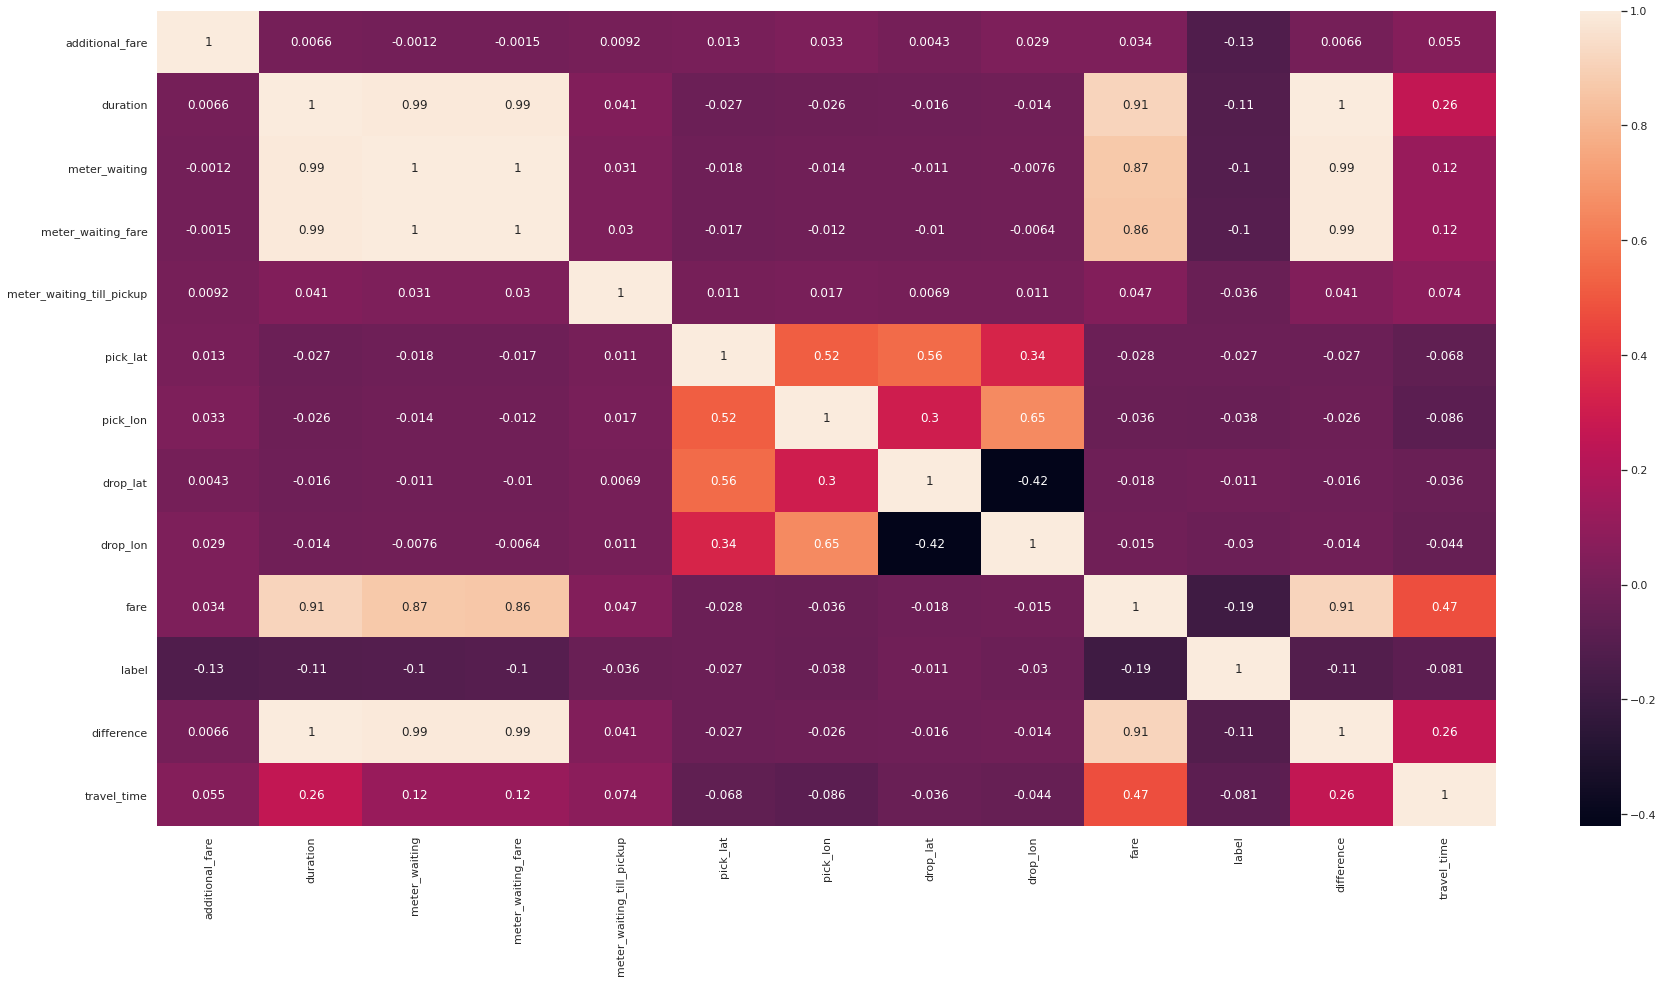

In [24]:
plt.figure(figsize=[30,15])
sns.heatmap(train_df.corr(), annot=True)
train_df_correlations = train_df.corr()

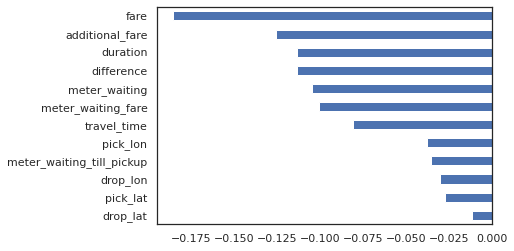

In [25]:
(train_df_correlations
     .label
     .drop('label') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [26]:
train_df2 = train_df.drop(['pickup_time','drop_time','pickup','drop','difference'],axis='columns')
train_df2.isnull().sum()
#train_df2 = train_df2.dropna(subset=['fare'])

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
travel_time                  0
dtype: int64

In [27]:
train_df2['label'].value_counts()

1    15441
0     1523
Name: label, dtype: int64

In [28]:
train_df2.isnull().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
travel_time                  0
dtype: int64

In [29]:
# train_df2['fare'] = train_df2['fare'] .fillna(train_df2.fare.mode())

In [30]:
# train_df2['additional_fare'] = train_df2['additional_fare'] .fillna(train_df2.additional_fare.median())

In [31]:
# train_df2['meter_waiting'] = train_df2['meter_waiting'] .fillna(train_df2.meter_waiting.median())

In [32]:
# train_df2['meter_waiting_fare'] = train_df2['meter_waiting_fare'] .fillna(train_df2.meter_waiting_fare.median())

In [33]:
# train_df2['meter_waiting_till_pickup'] = train_df2['meter_waiting_till_pickup'] .fillna(train_df2.meter_waiting_till_pickup.median())

In [34]:
train_df2.isnull().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
travel_time                  0
dtype: int64

In [35]:
train_df2['label'].value_counts()

1    15441
0     1523
Name: label, dtype: int64

In [36]:
train_df2['lat_change'] = abs(train_df2['pick_lat']- train_df2['drop_lat'])
train_df2['lon_change'] = abs(train_df2['pick_lon']- train_df2['drop_lon'])
train_df2['euc_distance'] = np.sqrt((train_df2['lat_change']**2) + (train_df2['lon_change']**2))
train_df2.head()

# train_df2['lat_change'] = np.deg2rad(train_df2['pick_lat']- train_df2['drop_lat'])
# train_df2['lon_change'] = np.deg2rad(train_df2['pick_lon']- train_df2['drop_lon'])
# train_df2['a'] = abs(np.sin(train_df2['lat_change']/2)**2 + np.cos(np.deg2rad(train_df2['pick_lat'])) * np.cos(np.deg2rad(train_df2['drop_lat'])) * np.sin(train_df2['lon_change']/2)**2)
# train_df2['c'] = 2 * np.arctan2(np.sqrt(train_df2['a']), np.sqrt(abs(1 - train_df2['a'])))
# kilo = 6373.0 * train_df2['c']
# train_df2['euc_distance'] = kilo
# train_df2 = train_df2.drop(['a','c'],axis='columns')
# train_df2.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,travel_time,lat_change,lon_change,euc_distance
tripid,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,1,778.0,0.04078,0.0210,0.045869
189125358,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,1,744.0,0.02784,0.0061,0.028500
189125719,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,1,1007.0,0.02830,0.0495,0.057019
189127273,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,1,327.0,0.00178,0.0076,0.007806
189129552,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,1,3225.0,0.21537,0.0320,0.217734


In [37]:
# train_df2[train_df2.euc_distance==0]

In [38]:
#train_df2[train_df2.travel_fare==0]

In [39]:
#train_df2[train_df2.travel_time==0]

In [40]:
# train_df2["label"] = train_df2["label"].map({"incorrect": 0, "correct":1})

In [41]:
#clean_df = train_df2.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis='columns')
clean_df = train_df2.drop(['pick_lat','pick_lon','drop_lat','drop_lon','lat_change','lon_change'],axis='columns')

In [42]:
# Q1 = clean_df.quantile(0.25)
# Q3 = clean_df.quantile(0.75)
# IQR = Q3 - Q1
# print(IQR)

In [43]:
# clean_df = clean_df[~((clean_df < (Q1 - 1.5 * IQR)) |(clean_df > (Q3 + 1.5 * IQR))).any(axis=1)]
# clean_df.shape

In [44]:
clean_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,euc_distance
count,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000
mean,12.940845,1703.383046,616.460799,31.325065,112.481608,311.208377,0.910222,1086.766093,0.043996
std,12.626491,8122.455726,7903.515567,456.066227,442.180690,575.801005,0.285872,1153.842037,0.415272
min,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,125.522500,1.000000,446.000000,0.013413
50%,10.500000,1010.000000,123.000000,0.115600,73.000000,211.050000,1.000000,811.000000,0.029034
75%,10.500000,1803.000000,351.000000,14.334400,144.000000,366.050000,1.000000,1402.000000,0.055471
max,221.000000,453872.000000,453650.000000,26198.601400,51288.000000,26945.990000,1.000000,46609.000000,53.857509


**Visualizing Features with Fare**

In [45]:
clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16964 entries, 189123628 to 213817296
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16964 non-null  float64
 1   duration                   16964 non-null  float64
 2   meter_waiting              16964 non-null  float64
 3   meter_waiting_fare         16964 non-null  float64
 4   meter_waiting_till_pickup  16964 non-null  float64
 5   fare                       16964 non-null  float64
 6   label                      16964 non-null  int64  
 7   travel_time                16964 non-null  float64
 8   euc_distance               16964 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,euc_distance
tripid,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,1,778.0,0.045869
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,1,744.0,0.028500
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1007.0,0.057019
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1,327.0,0.007806
189129552,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,3225.0,0.217734


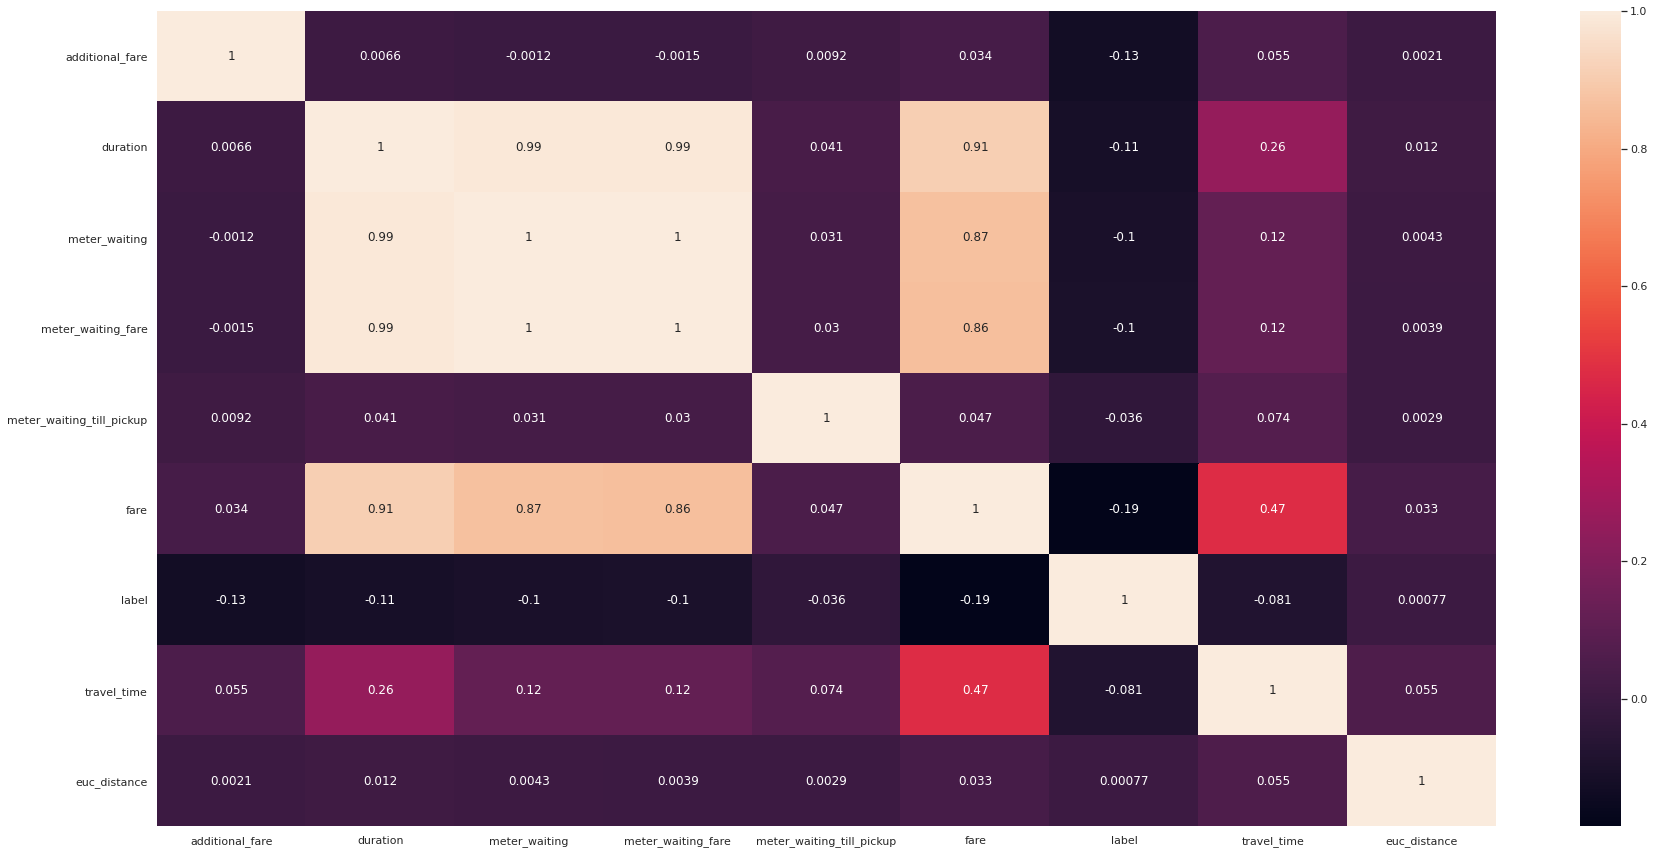

In [46]:
plt.figure(figsize=[30,15])
corr = clean_df.corr()
sns.heatmap(corr , annot=True)

In [47]:
# (corr
#      .label
#      .drop('label') # don't compare with myself
#      .sort_values(ascending=False)
#      .plot
#      .barh())

In [48]:
clean_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,euc_distance
count,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000,16964.000000
mean,12.940845,1703.383046,616.460799,31.325065,112.481608,311.208377,0.910222,1086.766093,0.043996
std,12.626491,8122.455726,7903.515567,456.066227,442.180690,575.801005,0.285872,1153.842037,0.415272
min,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,125.522500,1.000000,446.000000,0.013413
50%,10.500000,1010.000000,123.000000,0.115600,73.000000,211.050000,1.000000,811.000000,0.029034
75%,10.500000,1803.000000,351.000000,14.334400,144.000000,366.050000,1.000000,1402.000000,0.055471
max,221.000000,453872.000000,453650.000000,26198.601400,51288.000000,26945.990000,1.000000,46609.000000,53.857509


In [49]:
#clean_df[clean_df.duration>9825]

In [50]:
#clean_df[clean_df.additional_fare>112]

In [51]:
#clean_df[clean_df.meter_waiting_till_pickup>554]

# PLOTTING GRAPHS

**meter_waiting_till_pickup vs fare**

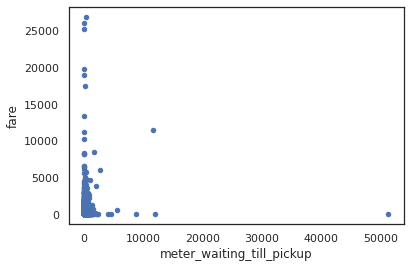

In [52]:
clean_df.plot(x ='meter_waiting_till_pickup', y='fare', kind = 'scatter')
plt.show()

In [53]:
# clean_df = clean_df[clean_df.meter_waiting_till_pickup<50000]

In [54]:
clean_df = clean_df[clean_df.fare<20000]

In [55]:
# clean_df.plot(x ='meter_waiting_till_pickup', y='fare', kind = 'scatter')
# plt.show()

In [56]:
# clean_df = clean_df[clean_df.meter_waiting_till_pickup<4000]

In [57]:
clean_df = clean_df[clean_df.fare<15000]

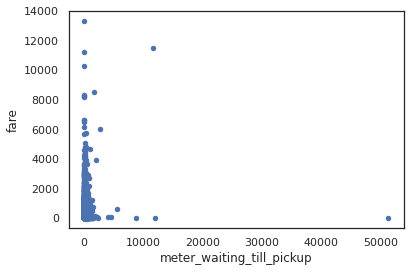

In [58]:
clean_df.plot(x ='meter_waiting_till_pickup', y='fare', kind = 'scatter')
plt.show()

In [59]:
# clean_df[clean_df.label >= 1].plot(x ='meter_waiting_till_pickup', y='fare', kind = 'scatter')
# plt.show()

In [60]:
# clean_df[clean_df.label <1].plot(x ='meter_waiting_till_pickup', y='fare', kind = 'scatter')
# plt.show()

In [61]:
#clean_df[clean_df.meter_waiting_till_pickup>40000].head()

**additional_fare vs fare**

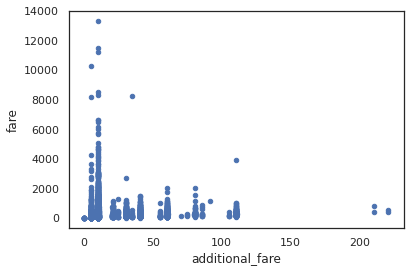

In [62]:
clean_df.plot(x ='additional_fare', y='fare', kind = 'scatter')
plt.show()

In [63]:
clean_df = clean_df[clean_df.additional_fare<2000]

In [64]:
clean_df = clean_df[clean_df.fare<15000]

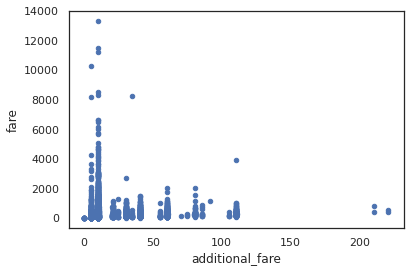

In [65]:
clean_df.plot(x ='additional_fare', y='fare', kind = 'scatter')
plt.show()

In [66]:
clean_df = clean_df[clean_df.additional_fare<200]

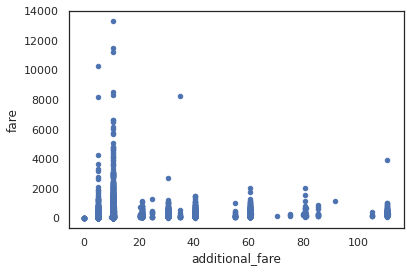

In [67]:
clean_df.plot(x ='additional_fare', y='fare', kind = 'scatter')
plt.show()

In [68]:
# clean_df[clean_df.label >=1].plot(x ='additional_fare', y='fare', kind = 'scatter')
# plt.show()

In [69]:
# clean_df[clean_df.label <1].plot(x ='additional_fare', y='fare', kind = 'scatter')
# plt.show()

**duration vs fare**

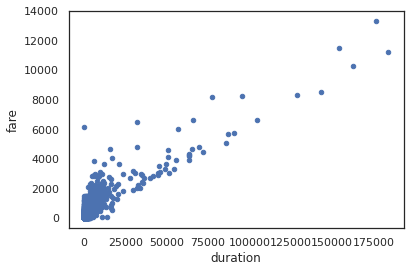

In [70]:
clean_df.plot(x ='duration', y='fare', kind = 'scatter')
plt.show()

In [71]:
clean_df = clean_df[clean_df.duration < 300000]

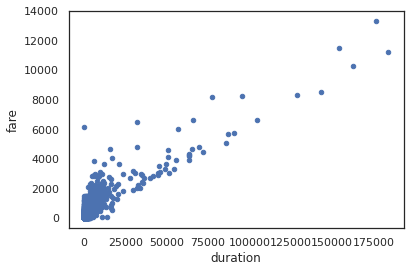

In [72]:
clean_df.plot(x ='duration', y='fare', kind = 'scatter')
plt.show()

In [73]:
# clean_df[clean_df.label >=1].plot(x ='duration', y='fare', kind = 'scatter')
# plt.show()

In [74]:
# clean_df[clean_df.label >=1].plot(x ='duration', y='fare', kind = 'scatter')
# plt.show()

In [75]:
# clean_df[clean_df.label <1].plot(x ='duration', y='fare', kind = 'scatter')
# plt.show()

In [76]:
# clean_df[clean_df.fare>25000].head()

**Plot Meter Waiting**

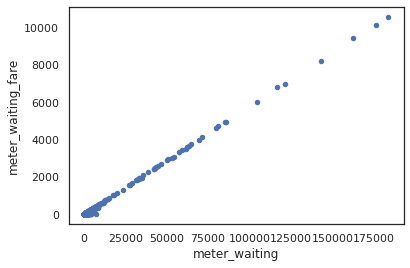

In [77]:
clean_df.plot(x ='meter_waiting', y='meter_waiting_fare', kind = 'scatter')
plt.show()

In [78]:
# Phi Coefficient is the same as Pearson for two binary variables
(clean_df["meter_waiting"]
     .corr(clean_df["meter_waiting_fare"], method="pearson")
)

0.9988898139800396

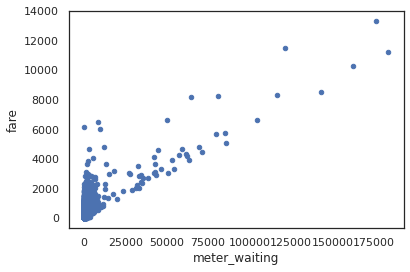

In [79]:
clean_df.plot(x ='meter_waiting', y='fare', kind = 'scatter')
plt.show()

In [80]:
# clean_df[clean_df.label>=1].plot(x ='meter_waiting', y='fare', kind = 'scatter')
# plt.show()

In [81]:
# clean_df[clean_df.label<1].plot(x ='meter_waiting', y='fare', kind = 'scatter')
# plt.show()

**meter_waiting_time vs fare**

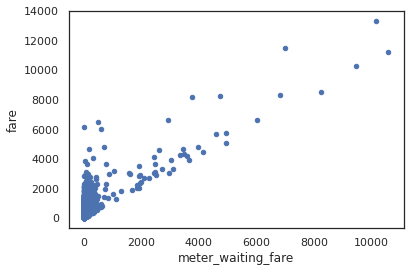

In [82]:
clean_df.plot(x ='meter_waiting_fare', y='fare', kind = 'scatter')
plt.show()

In [83]:
# clean_df[clean_df.label>=1].plot(x ='meter_waiting_fare', y='fare', kind = 'scatter')
# plt.show()

In [84]:
# clean_df[clean_df.label<1].plot(x ='meter_waiting_fare', y='fare', kind = 'scatter')
# plt.show()

**euc_distance vs fare**

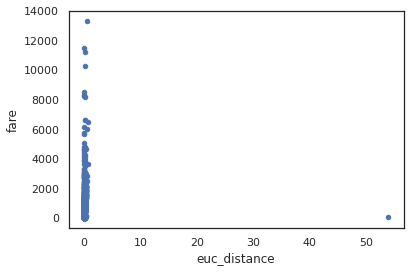

In [85]:
clean_df.plot(x ='euc_distance', y='fare', kind = 'scatter')
plt.show()

In [86]:
clean_df = clean_df[clean_df.euc_distance<10]
# clean_df = clean_df[clean_df.euc_distance<1000]

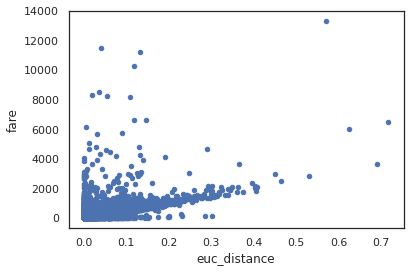

In [87]:
clean_df.plot(x ='euc_distance', y='fare', kind = 'scatter')
plt.show()

In [88]:
clean_df = clean_df[clean_df.euc_distance<0.6]
# clean_df = clean_df[clean_df.euc_distance<65]

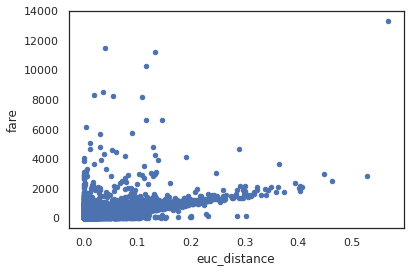

In [89]:
clean_df.plot(x ='euc_distance', y='fare', kind = 'scatter')
plt.show()

In [90]:
clean_df[clean_df.euc_distance>0.5]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,euc_distance
tripid,,,,,,,,,
203475249,10.5,9271.0,790.0,45.662,115.0,2841.27,1,8481.0,0.528973
208649108,10.5,176620.0,176164.0,10173.378,10.0,13350.32,0,456.0,0.568757


In [91]:
# clean_df[clean_df.label>=1].plot(x ='euc_distance', y='fare', kind = 'scatter')
# plt.show()

In [92]:
# clean_df[clean_df.label<1].plot(x ='euc_distance', y='fare', kind = 'scatter')
# plt.show()

In [93]:
# clean_df[clean_df.euc_distance>50].head()

Travel Time

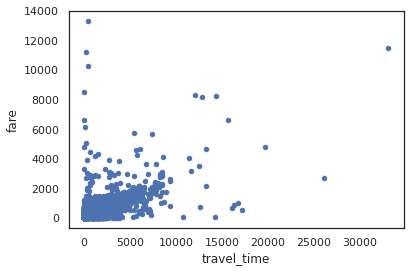

In [94]:
clean_df.plot(x ='travel_time', y='fare', kind = 'scatter')
plt.show()

In [95]:
#clean_df = clean_df[clean_df.travel_time<25000]

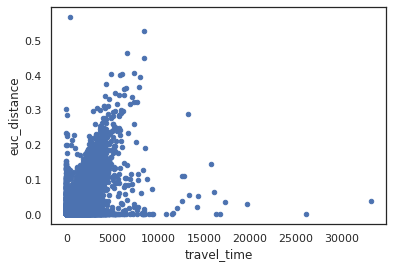

In [96]:
clean_df.plot(x ='travel_time', y='euc_distance', kind = 'scatter')
plt.show()

In [97]:
# clean_df = clean_df[clean_df.meter_waiting_till_pickup<40000]
# clean_df = clean_df[clean_df.additional_fare<2000]
# clean_df = clean_df[clean_df.euc_distance<10]

In [98]:
# clean_df.plot(x ='travel_time', y='travel_fare', kind = 'scatter')
# plt.show()

# Final Plot

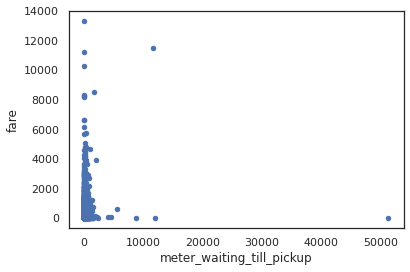

In [99]:
clean_df.plot(x ='meter_waiting_till_pickup', y='fare', kind = 'scatter')
plt.show()

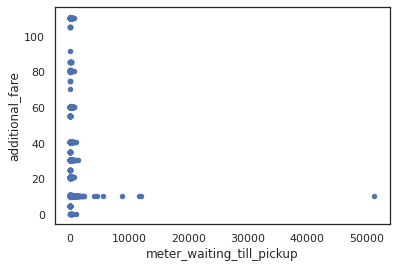

In [100]:
clean_df.plot(x ='meter_waiting_till_pickup', y='additional_fare', kind = 'scatter')
plt.show()

In [101]:
#clean_df[clean_df.meter_waiting_till_pickup>6000].head()

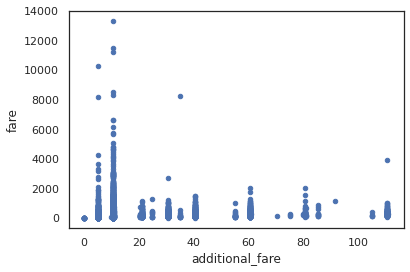

In [102]:
clean_df.plot(x ='additional_fare', y='fare', kind = 'scatter')
plt.show()

In [103]:
#clean_df = clean_df[clean_df.fare<10000]

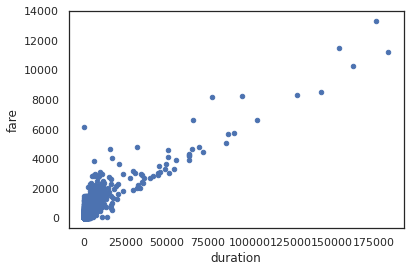

In [104]:
clean_df.plot(x ='duration', y='fare', kind = 'scatter')
plt.show()

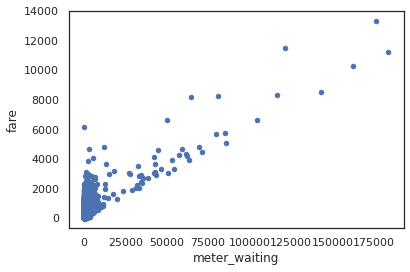

In [105]:
clean_df.plot(x ='meter_waiting', y='fare', kind = 'scatter')
plt.show()

**euc_distance vs fare**

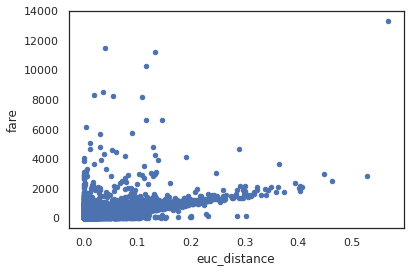

In [106]:
clean_df.plot(x ='euc_distance', y='fare', kind = 'scatter')
plt.show()

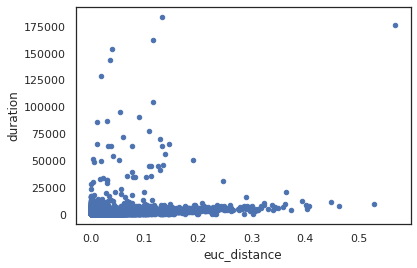

In [107]:
clean_df.plot(x ='euc_distance', y='duration', kind = 'scatter')
plt.show()

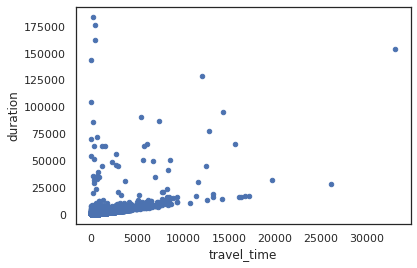

In [108]:
clean_df.plot(x ='travel_time', y='duration', kind = 'scatter')
plt.show()

In [109]:
clean_df[clean_df.travel_time<1]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,euc_distance
tripid,,,,,,,,,
191056435,10.5,80.0,80.0,0.0000,51288.0,60.50,1,0.0,0.014278
193653017,0.0,1560.0,0.0,0.0000,540.0,0.00,0,0.0,0.000172
195445714,10.5,27.0,27.0,0.0000,85.0,60.50,0,0.0,0.018963
197020223,10.5,49.0,49.0,2.8567,30.0,63.35,1,0.0,0.000010
197271380,10.5,29.0,29.0,0.0000,67.0,507.22,0,0.0,0.108635
197546607,10.5,28.0,28.0,0.0000,132.0,60.50,0,0.0,0.084772
199104080,21.0,49.0,49.0,2.8567,681.0,83.74,0,0.0,0.000969
200235706,10.5,53.0,53.0,3.0899,4620.0,63.47,0,0.0,0.020280
203915670,10.5,1300.0,1300.0,0.0000,688.0,60.50,0,0.0,0.008285


In [110]:
#clean_df = clean_df.drop(['meter_waiting'],axis='columns')

In [111]:
clean_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,euc_distance
count,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000
mean,12.894425,1575.675162,493.714159,24.307048,112.331563,302.428243,0.910678,1081.804720,0.040708
std,12.240942,4254.457486,3890.196636,224.832832,441.912639,385.174152,0.285216,1081.432484,0.040630
min,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,125.485000,1.000000,446.000000,0.013412
50%,10.500000,1009.000000,123.000000,0.115600,73.000000,210.805000,1.000000,811.000000,0.029033
75%,10.500000,1799.750000,350.000000,14.225200,144.000000,365.327500,1.000000,1401.750000,0.055431
max,111.000000,183996.000000,183756.000000,10591.618800,51288.000000,13350.320000,1.000000,33104.000000,0.568757


# **Model Selection Using Cross Validation**

In [112]:
clean_df = clean_df.drop(['meter_waiting_till_pickup'],axis='columns')

In [113]:
X_train = clean_df.drop(['label'],axis='columns')
Y_train = clean_df['label']
Y_train.head()

tripid
189123628    1
189125358    1
189125719    1
189127273    1
189129552    1
Name: label, dtype: int64

In [114]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scalar=PCA()

X_train = scaler.fit_transform(X_train)

In [115]:
kfold = StratifiedKFold(n_splits=10)

In [116]:
random_state = 2

In [117]:
# #upsampling method

# example_params = {
#         #'n_estimators': 100,
#         #'max_depth': 5,
#         #'random_state': 13
#     }

# def score_model(model, params, cv=None):
#     """
#     Creates folds manually, and upsamples within each fold.
#     Returns an array of validation (recall) scores
#     """
#     if cv is None:
#         cv = KFold(n_splits=10, random_state=42)

#     smoter = SMOTE(random_state=42)
    
#     scores = []

#     for train_fold_index, val_fold_index in cv.split(X_train, Y_train):
#         # Get the training data
#         X_train_fold, y_train_fold = X_train[train_fold_index], Y_train[train_fold_index]
#         # Get the validation data
#         X_val_fold, y_val_fold = X_train[val_fold_index], Y_train[val_fold_index]

#         # Upsample only the data in the training section
#         X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
#         # Fit the model on the upsampled training data
#         model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
#         # Score the model on the (non-upsampled) validation data
#         score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
#         scores.append(score)
#     return np.array(scores)

In [118]:
classifiers = []
classifiers.append(XGBClassifier())
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(RidgeClassifier())
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(naive_bayes.BernoulliNB())
classifiers.append(naive_bayes.GaussianNB())
classifiers.append(SGDClassifier())
# classifiers.append(RadiusNeighborsClassifier())
classifiers.append(BaggingClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'f1', cv = kfold, n_jobs=4)) #without upsampling
    #cv_results.append(score_model(classifier, example_params, cv=None))  #with upsampling
#     imba_pipeline = make_pipeline(SMOTE(random_state=42), classifier)
#     cv_results.append(cross_val_score(imba_pipeline, X_train, y =Y_train, scoring='f1', cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [119]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees", "RidgeRegression","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression",
"LinearDiscriminantAnalysis","BNB","GNB","SGDClassifier","BaggingClassifier"]}) 
#"RadiusNeighborsClassifier"

In [120]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.975037,0.004223,XGB
1,0.971016,0.002410,SVC
2,0.960443,0.003441,DecisionTree
3,0.961521,0.003735,AdaBoost
4,0.975392,0.003390,RandomForest
5,0.974820,0.004564,ExtraTrees
6,0.955326,0.001136,RidgeRegression
7,0.972438,0.002778,GradientBoosting
8,0.975875,0.002847,MultipleLayerPerceptron
9,0.974958,0.003592,KNeighboors


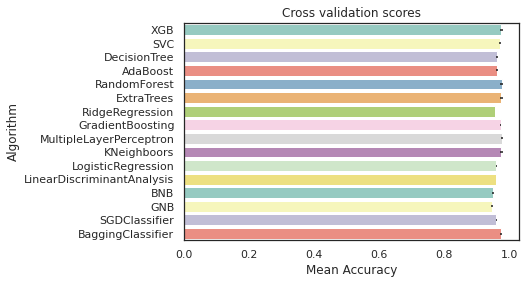

In [121]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [122]:
XGBC = XGBClassifier()
# xgbc_param_grid = {
#    "learning_rate"    : [0.1, 0.2, 0.3] , #[0.1] #[0.3]
#    "max_depth"        : [3,4,5,6],  #[5] #[3]
#    "n_estimators"     : [180,200,220], #[100] #[150]
#    "min_child_weight" : [ 1, 3, 5],   #[] #[1]
#    "gamma"            : [ 0.05, 0.1, 0.15, 0.2 ], #[0.2] #[0.2]
#    "colsample_bytree" : [0.5 , 0.7 ,1.0 ],   #[] #[1]
#    "subsample"       : [0.8,1]
#     }
# xgbc_param_grid = {
#    "learning_rate"    : [0.15,0.1,0.05] , #[0.1]
#    "max_depth"        : [5,6,7],    #[7]
#    "n_estimators"     : [100,200,300],    #[100]
#    #"min_child_weight" : [1,2,3], #[2]
#    "gamma"            : [0.1,0.2,0.3], #[0.25]
#    #"scale_pos_weight" : [1,0.1],
# #    "colsample_bytree" : [0.9,1 ],   #[] #[1]
# #    "subsample"       : [0.9,1]
#     }

xgbc_param_grid = {
   "learning_rate"    : [0.15,0.1,0.05] , #[0.1]
   "max_depth"        : [4,5,6],    #[6]
   "n_estimators"     : [150,100,200,300],    #[150]
   #"min_child_weight" : [1,2,3], #[2]
   "gamma"            : [0.15,0.2,0.25], #[0.2]
   #"scale_pos_weight" : [1,0.1],
#    "colsample_bytree" : [0.9,1 ],   #[] #[1]
#    "subsample"       : [0.9,1]
    }

gsXGBC = GridSearchCV(XGBC,param_grid =xgbc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsXGBC.fit(X_train,Y_train)

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 14.0min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed: 19.3min finished


0.9764708003965733

In [123]:
XGBC_best

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [124]:
# LR = LogisticRegression(random_state = random_state)
# lr_param_grid = {'penalty' : ['l1', 'l2'], 
#                    'solver' : ['liblinear', 'saga'],               
#                   'C': [1, 10, 50, 100, 300],
#                   'class_weight' : [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]}

# gsLR = GridSearchCV(LR,param_grid =lr_param_grid, cv=kfold, scoring='f1', n_jobs= 4, verbose = 1)

# gsLR.fit(X_train,Y_train)

# LR_best = gsLR.best_estimator_

# # Best score
# gsLR.best_score_

In [125]:
# gsLR.best_score_

In [ ]:
RFC = RandomForestClassifier()
rfc_param_grid = {
   #'bootstrap': [True, False],
   'max_depth': [30], #[20] [20]
   #'max_features': ['auto', 'sqrt'],
   #'min_samples_leaf': [1, 2, 4],
   #'min_samples_split': [2, 5, 10],
   'n_estimators': [2250] #[1000] [1250]
    }

gsRFC = GridSearchCV(RFC,param_grid =rfc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
RFC_best

In [ ]:
# LDA = LinearDiscriminantAnalysis()
# lda_param_grid = {'n_components' : [1, 2, 5, 10, 100], 
#                    'solver' : ['svd', 'lsqr','eigen']}

# gsLDA = GridSearchCV(LDA,param_grid =lda_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

# gsLDA.fit(X_train,Y_train)

# LDA_best = gsLDA.best_estimator_

# # Best score
# gsLDA.best_score_

In [ ]:
# LDA_best

In [ ]:
# RR = RidgeClassifier(random_state = random_state)
# rr_param_grid = {'solver' : ['liblinear', 'saga'],               
#                   'alpha' : [ 0.01, 0.1, 1, 5, 10, 50, 100]}

# gsRR = GridSearchCV(RR,param_grid =rr_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

# gsRR.fit(X_train,Y_train)

# RR_best = gsRR.best_estimator_

# # Best score
# gsRR.best_score_

In [ ]:
# RR_best

In [ ]:
ETC = ExtraTreesClassifier()
# etc_param_grid = {
#    #'bootstrap': [True, False],
#    'max_depth': [40,50,60], #[20]
#    'max_features': ['auto', 'sqrt'],
#    'min_samples_leaf': [1, 2, 4],
#    'min_samples_split': [2, 5, 10],
#    'n_estimators': [1200,1300,1400] #[1000][1500]
#     }

etc_param_grid = {
   #'bootstrap': [True, False],
   'max_depth': [50,60], #[20]
   'max_features': ['sqrt'],
   'min_samples_leaf': [1],
   'min_samples_split': [2],
   'n_estimators': [1200,1300] #[1000][1500]
    }

gsETC = GridSearchCV(ETC,param_grid =etc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsETC.fit(X_train,Y_train)


ETC_best = gsETC.best_estimator_

# Best score
gsETC.best_score_

In [ ]:
ETC_best

In [ ]:
# KNC = KNeighborsClassifier()
# knc_param_grid = {
#     'weights': ['uniform' , 'distance'],
#    #'bootstrap': [True, False],
#    #'max_depth': [10, 20, 30], #[20]
#    #'max_features': ['auto', 'sqrt'],
#    #'min_samples_leaf': [1, 2, 4],
#    #'min_samples_split': [2, 5, 10],
#     'n_neighbors': [3,5,7,11,19,49],
#     'metric': ['euclidean' , 'manhattan']
#     }

# gsKNC = GridSearchCV(KNC,param_grid =knc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

# gsKNC.fit(X_train,Y_train)

# KNC_best = gsKNC.best_estimator_

# # Best score
# gsKNC.best_score_

In [ ]:
# KNC_best

In [ ]:
GBC = GradientBoostingClassifier()
# gbc_param_grid = {
#     #"loss":["deviance"],
#     "learning_rate": [0.05, 0.1, 0.2], #[0.1] #[0.1]
#     #"min_samples_split": np.linspace(0.1, 0.5, 4),
#     #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
#     "max_depth":[6,8,10], #[5] #[4]
#     #"max_features":["log2","sqrt"],
#     #"criterion": ["friedman_mse", "mae"],
#     #"subsample":[0.5, 0.8, 0.9, 1.0],
#     "n_estimators":[150, 200, 250] #[100] #[200]
#     }


gbc_param_grid = {
    #"loss":["deviance"],
    "learning_rate": [0.05], #[0.1] #[0.1]
    #"min_samples_split": np.linspace(0.1, 0.5, 4),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[6,7,8], #[5] #[4]
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse", "mae"],
    #"subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[150, 200, 250] #[100] #[200]
    }

gsGBC = GridSearchCV(GBC,param_grid =gbc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
GBC_best 

In [ ]:
MLPC = MLPClassifier()
mlpc_param_grid = {
#     #"loss":["deviance"],
#     "learning_rate": [0.05, 0.1, 0.2], #[0.1] #[0.1]
#     #"min_samples_split": np.linspace(0.1, 0.5, 4),
#     #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
#     "max_depth":[4 , 5, 6], #[5] #[4]
#     #"max_features":["log2","sqrt"],
#     #"criterion": ["friedman_mse", "mae"],
#     #"subsample":[0.5, 0.8, 0.9, 1.0],
#     "n_estimators":[100, 200, 300] #[100] #[200]
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }

# mlpc_param_grid = {
# #     #"loss":["deviance"],
# #     "learning_rate": [0.05, 0.1, 0.2], #[0.1] #[0.1]
# #     #"min_samples_split": np.linspace(0.1, 0.5, 4),
# #     #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
# #     "max_depth":[4 , 5, 6], #[5] #[4]
# #     #"max_features":["log2","sqrt"],
# #     #"criterion": ["friedman_mse", "mae"],
# #     #"subsample":[0.5, 0.8, 0.9, 1.0],
# #     "n_estimators":[100, 200, 300] #[100] #[200]
#     'hidden_layer_sizes': [(50,50,50)],
#     'activation': ['tanh'],
#     'solver': ['adam'],
#     'alpha': [ 0.05],
#     'learning_rate': ['constant']
#     }

gsMLPC = GridSearchCV(MLPC,param_grid =mlpc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsMLPC.fit(X_train,Y_train)

MLPC_best = gsMLPC.best_estimator_

# Best score
gsMLPC.best_score_


In [ ]:
MLPC_best

In [ ]:
best_data = [ [ 'RandomForestClassifier',gsRFC.best_score_], ['ExtraTrees',gsETC.best_score_], ['GradientBoosing',gsGBC.best_score_], ['XGB',gsXGBC.best_score_], ['MLPC',gsMLPC.best_score_]]
cv_best_algo_df = pd.DataFrame(best_data, columns = ['Algo', 'Best Score'])
cv_best_algo_df

# Getting Output

In [ ]:
# votingC = VotingClassifier(estimators=[('xgbc', XGBC_best), ('gbc', GBC_best),('rfc', RFC_best)], voting='soft', n_jobs=4)

# votingC = votingC.fit(X_train, Y_train)

In [127]:
test_df = pd.read_csv("/kaggle/input/fare-dataset/test.csv", index_col="tripid")

In [128]:
test_df["pickup"] = pd.to_datetime(test_df["pickup_time"])
test_df["drop"] = pd.to_datetime(test_df["drop_time"])
test_df ['difference'] = test_df["drop"] - test_df["pickup"]
test_df ['difference'] = test_df ['difference']/np.timedelta64(1,'s')
test_df['duration'] = np.where(abs(test_df['duration']-test_df['difference']) > 120, test_df['difference'], test_df['duration'])
test_df["travel_time"] = test_df["duration"] - test_df["meter_waiting"]
#test_df["travel_fare"] = test_df["fare"] - test_df["meter_waiting_fare"] - test_df["additional_fare"]

#test_df['pickup_hour'] = test_df["pickup"].dt.hour

#test_df = test_df.drop(['pickup_time','drop_time','pickup','drop','difference'],axis='columns')
# # test_df['duration'] = test_df['duration'].fillna(test_df ['difference'])
# test_df.info()
# test_df.head()

# # new_df = train_df["pickup_time"]-train_df["drop_time"]
# # train_df.info()
# # train_df.head()
# test_df.isnull().sum()
# test_df.head()

In [ ]:
# test_df['pickup_hour'] = np.where(abs(test_df['pickup_hour']) <6, 1, test_df['pickup_hour'])
# test_df['pickup_hour'] = np.where(abs(test_df['pickup_hour']) >19, 1, test_df['pickup_hour'])
# test_df['pickup_hour'] = np.where(abs(test_df['pickup_hour']) >1, 1, test_df['pickup_hour'])

In [129]:
test_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,difference,travel_time
count,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,11.088095,1541.849347,508.502099,24.671655,119.863106,6.969246,80.008728,6.970008,80.010145,293.278057,1542.054571,1033.347248
std,5.359602,5952.439797,5784.005855,333.515641,793.233190,0.217809,0.251873,0.218826,0.252229,436.730282,5952.333969,998.044944
min,0.000000,24.000000,0.000000,0.000000,0.000000,5.943130,79.817700,5.936600,79.818000,0.000000,0.000000,0.000000
25%,10.500000,540.000000,30.000000,0.000000,26.000000,6.864810,79.871600,6.864950,79.871300,126.077500,540.000000,447.000000
50%,10.500000,983.000000,116.000000,0.000000,72.000000,6.913605,79.900500,6.915460,79.902250,203.950000,960.000000,787.000000
75%,10.500000,1723.000000,336.250000,11.744200,138.000000,7.068875,79.963225,7.073505,79.967825,344.075000,1740.000000,1343.250000
max,160.500000,447230.000000,446934.000000,25760.361800,55571.000000,8.425010,80.776400,8.421730,80.805500,26844.330000,447240.000000,26601.000000


In [130]:
test_df.isnull().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
pickup                       0
drop                         0
difference                   0
travel_time                  0
dtype: int64

In [ ]:
#test_df[test_df.travel_fare <0]

In [ ]:
#test_df[test_df.travel_fare==0]

In [ ]:
test_df[test_df.travel_time==0]

In [131]:
test_df[test_df.travel_time<0]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup,drop,difference,travel_time
tripid,,,,,,,,,,,,,,,,


In [132]:
test_df['lat_change'] = abs(test_df['pick_lat']- test_df['drop_lat'])
test_df['lon_change'] = abs(test_df['pick_lon']- test_df['drop_lon'])
test_df['euc_distance'] = np.sqrt((test_df['lat_change']**2) + (test_df['lon_change']**2))

#test_df["travel_time"] = test_df["duration"] - test_df["meter_waiting"]
test_df.head()

test_df2 = test_df.drop(['pickup_time','drop_time','pickup','drop','difference','pick_lat','pick_lon','drop_lat','drop_lon','lat_change','lon_change', 'meter_waiting_till_pickup'],axis='columns')
#test_df2 = test_df.drop(['pickup_time','drop_time','pick_lat','drop_lat','pick_lon','drop_lon'],axis='columns')
#test_df2 = test_df.drop(['pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon','lat_change','lon_change','meter_waiting'],axis='columns')
#test_df2 = test_df.drop(['pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon','lat_change','lon_change','meter_waiting_fare'],axis='columns')

test_df2.isnull().sum()

additional_fare       0
duration              0
meter_waiting         0
meter_waiting_fare    0
fare                  0
travel_time           0
euc_distance          0
dtype: int64

In [133]:
test_df[test_df.euc_distance==0]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup,drop,difference,travel_time,lat_change,lon_change,euc_distance
tripid,,,,,,,,,,,,,,,,,,,
213644527,5.0,53.0,51,2.973300,0,2/3/2020 7:38,2/3/2020 7:38,6.88371,79.9076,6.88371,79.9076,62.97,2020-02-03 07:38:00,2020-02-03 07:38:00,0.0,2.0,0.0,0.0,0.0
214443986,5.0,32.0,30,1.749000,0,2/6/2020 20:54,2/6/2020 20:54,6.97871,79.9958,6.97871,79.9958,61.74,2020-02-06 20:54:00,2020-02-06 20:54:00,0.0,2.0,0.0,0.0,0.0
214459662,5.0,44.0,42,2.448600,0,2/7/2020 0:09,2/7/2020 0:10,6.93729,79.9796,6.93729,79.9796,62.44,2020-02-07 00:09:00,2020-02-07 00:10:00,60.0,2.0,0.0,0.0,0.0
215383717,5.0,32.0,30,1.749000,0,2/11/2020 12:20,2/11/2020 12:20,6.81234,79.8814,6.81234,79.8814,61.74,2020-02-11 12:20:00,2020-02-11 12:20:00,0.0,2.0,0.0,0.0,0.0
215728475,5.0,253.0,250,14.575000,0,2/12/2020 18:21,2/12/2020 18:25,6.90056,79.9123,6.90056,79.9123,74.57,2020-02-12 18:21:00,2020-02-12 18:25:00,240.0,3.0,0.0,0.0,0.0
215874000,10.5,1880.0,718,41.554649,18,2/13/2020 13:11,2/13/2020 13:42,7.02177,79.9442,7.02177,79.9442,338.75,2020-02-13 13:11:00,2020-02-13 13:42:00,1860.0,1162.0,0.0,0.0,0.0
216770871,30.5,5081.0,4221,246.084300,16,2/17/2020 11:00,2/17/2020 12:25,6.85024,79.8690,6.85024,79.8690,412.02,2020-02-17 11:00:00,2020-02-17 12:25:00,5100.0,860.0,0.0,0.0,0.0
217244029,10.5,634.0,50,2.915000,96,2/19/2020 16:20,2/19/2020 16:30,6.93546,79.9134,6.93546,79.9134,112.76,2020-02-19 16:20:00,2020-02-19 16:30:00,600.0,584.0,0.0,0.0,0.0
217980822,30.5,4168.0,3853,224.629900,22,2/23/2020 13:19,2/23/2020 14:29,6.89589,79.9048,6.89589,79.9048,324.36,2020-02-23 13:19:00,2020-02-23 14:29:00,4200.0,315.0,0.0,0.0,0.0


In [ ]:
test_df[test_df.duration<1]

In [134]:
test_df2.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,fare,travel_time,euc_distance
count,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,11.088095,1541.849347,508.502099,24.671655,293.278057,1033.347248,0.039963
std,5.359602,5952.439797,5784.005855,333.515641,436.730282,998.044944,0.038596
min,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,540.000000,30.000000,0.000000,126.077500,447.000000,0.014029
50%,10.500000,983.000000,116.000000,0.000000,203.950000,787.000000,0.029098
75%,10.500000,1723.000000,336.250000,11.744200,344.075000,1343.250000,0.054315
max,160.500000,447230.000000,446934.000000,25760.361800,26844.330000,26601.000000,0.467416


In [135]:
test = scaler.transform(test_df2)

In [ ]:
#XGBC_best = XGBClassifier().fit(X_train , Y_train)

In [136]:
#a = votingC.predict(test) #GBC_best.predict_proba(test)
a = XGBC_best.predict(test)
test_df2['prediction'] = a 

In [137]:
test_df2['prediction'].value_counts()

1    8173
0     403
Name: prediction, dtype: int64

In [139]:
#output_df = test_df2.drop(['additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','fare','lat_change','lon_change'],axis='columns')
# output_df = test_df2['prediction']
output_df = test_df2.drop(['additional_fare','duration','fare','euc_distance','meter_waiting_fare','meter_waiting','travel_time'],axis='columns')

output_df.head()
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   prediction  8576 non-null   int64
dtypes: int64(1)
memory usage: 134.0 KB


In [140]:
output_df.prediction.describe()

count    8576.000000
mean        0.953008
std         0.211633
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: prediction, dtype: float64

In [ ]:
output_df.to_csv('submission_30.csv', index=True)